https://journals.ametsoc.org/view/journals/atot/27/3/2009jtecho725_1.xml

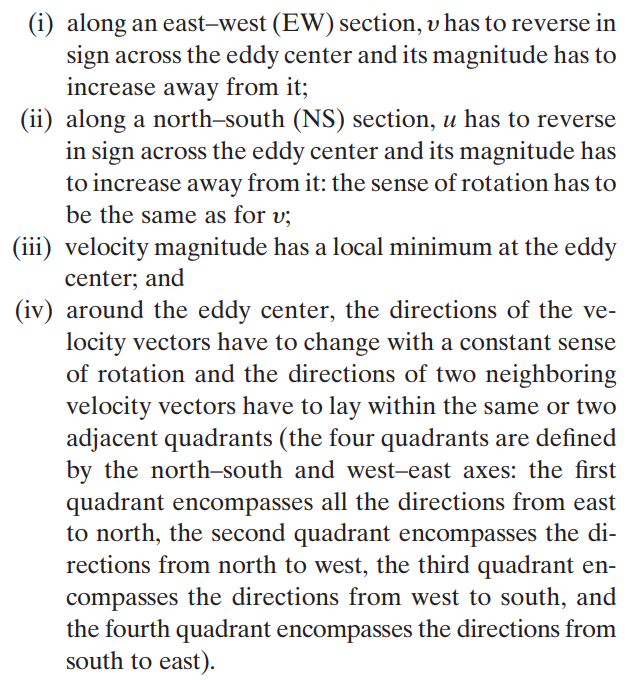

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [4]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_u = f.variables['ugos'].data.squeeze()
vel_v = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

imputed_vel_u = interpolate_missing_point(vel_u, np.ma.masked_invalid(vel_u).mask)
imputed_vel_v = interpolate_missing_point(vel_v, np.ma.masked_invalid(vel_v).mask)

## Method Parameters:

In [12]:
a = 4
b = 3

## Constraint 1
First part of constraint 1 is checking of changes of sign in v in the E-W direction

<IPython.core.display.Javascript object>


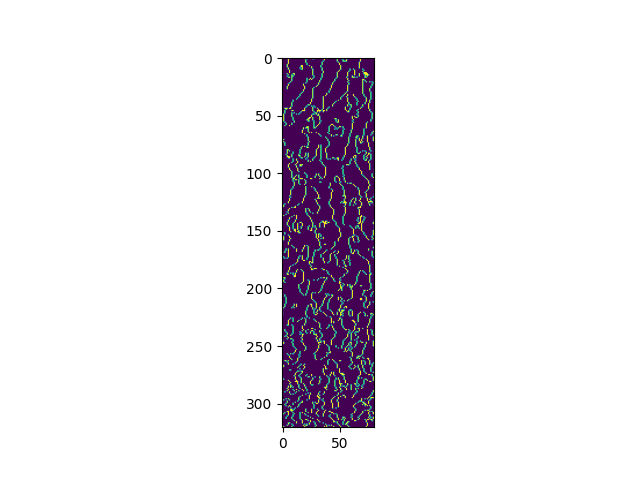

In [15]:
change_of_sign_v = (np.diff(np.sign(imputed_vel_v), axis=1) != 0)*1
plt.figure()
plt.imshow(change_of_sign_v)

Second part is to check sign and magnitude a points away

In [14]:
satifies_crit_1 = []